# Clustering using betweenness-based graph algorithms

In [44]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import warnings
import itertools
%run data_cleaning.ipynb

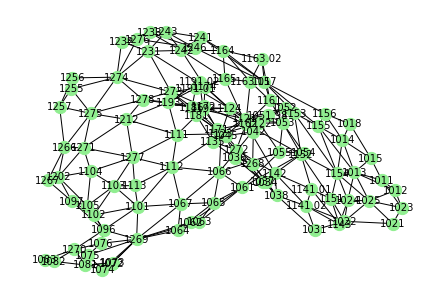

In [45]:
# import data
centroid_locations = pd.read_csv(r"data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"data\MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv(r"data\MetroLinkStations_NS.csv")
census_data = data = pd.read_csv(r"data\B08119_stl_city.csv")
race_data = pd.read_csv(r"data\B08105_stl_city.csv")
stl = nx.read_weighted_edgelist(r"data\weighted_dual_list",delimiter='%')
nx.draw(stl, with_labels=True, node_size=150, node_color='lightgreen', font_size=10)

In [46]:
by_tract = clean(census_data, race_data)
centroid_locations_small = centroid_locations[['NAMELSAD','INTPTLAT','INTPTLON']]
centroid_locations_small = centroid_locations_small.rename(columns = {"NAMELSAD": "location", "INTPTLAT" : "LAT", "INTPTLON" : "LON"})
full_data = by_tract.merge(centroid_locations_small, on='location')
full_data.head()
print(list(full_data['race weight']))
print(list(full_data['race weight (pop)']))

[0.007498567870084898, 0.012480449012956753, 0.013909360658586665, 0.010098929603573566, 0.008554160256946634, 0.009191377612430244, 0.0099058334352452, 0.01934823606650232, 0.009056210294600388, 0.008631398724277982, 0.007408456324864993, 0.01208782013735574, 0.007311908240700811, 0.004737292662989258, 0.010041000753075057, 0.01261561633078661, 0.014160385677413541, 0.010182604609849192, 0.011263943152488045, 0.010948552744218378, 0.005290835012197241, 0.008541287179058077, 0.008090729452958556, 0.003495040646743433, 0.0024394482598816963, 0.003495040646743433, 0.005046246532314644, 0.007813958278354563, 0.0031281579269195367, 0.008155094842401345, 0.002233479013664772, 0.012744347109672188, 0.0024330117209374175, 0.0035787156530190586, 0.004705109968267863, 0.008161531381345623, 0.00345642141307776, 0.00570277350463109, 0.007743156349967495, 0.0044347753326081495, 0.005033373454426086, 0.005426002330027098, 0.0041000753075056484, 0.0058829965950708985, 0.001531896268738374, 0.0030187

In [47]:
def mod_max(graph, k):
    tolerance = 1e-5
    orig = graph.copy()
    to_return = graph.copy()
    q = 0
    q_new = 0
    partition = [orig]
    new_partition = []

    while (len(partition) < k):
        for G in partition:
            # compute modularity matrix B
            G_nodes = list(G.nodes())
            s = np.zeros(len(G_nodes))
            A = nx.to_numpy_array(G)
            degs = list(dict(G.degree()).values())
            B = np.zeros(np.shape(A))
            n = len(G_nodes)
            m = len(G.edges())
            for i in range(n):
                for j in range(n):
                    B[i][j] = A[i][j] - degs[i]*degs[j]/(2*m)
            # find leading eigenvector u of B
            val, vec = np.linalg.eig(B)
            idx = np.argsort(val)[-1]
            largest_vec = vec[:,idx]
            
            # divide nodes into two groups by sign of leading eigenvector
            for i in range(len(largest_vec)):
                if largest_vec[i].real < np.mean(largest_vec):
                    s[i] = -1
                else:
                    s[i] = 1
            
            # create new subgraphs
            n1 = [G_nodes[i] for i in range(n) if s[i] == 1]
            n2 = [G_nodes[i] for i in range(n) if s[i] == -1]
            if len(n1) >= 1:
                new_partition.append(G.subgraph(n1))
            if len(n2) >= 1:
                new_partition.append(G.subgraph(n2))
            
            # update q_new
            q_new = q_new + B.sum()
        
        
        # either stop or re-partition graph
        q_new = q_new / (2*m)
        if abs(q_new - q) > tolerance and q_new < q:
            return partition
        
        else:
            q = q_new
            q_new = 0 
            partition = new_partition
            new_partition = []

    if len(partition) > k: # (this happens if k is odd)
        num_to_combine = len(partition) - k # we need to re-combine this many graphs to get back to k subgraphs
        pairs = [(partition[i], partition[i + 1]) for i in range(0, len(partition), 2)]
        to_test = list(itertools.combinations(pairs, num_to_combine))
        
        # test modularity of all possible combinations to make partition have length k
        best_modularity = 0
        test_idx = 0
        best_test_idx = 0
        for test in to_test:
            partition_copy = partition.copy()
            # remove the pair from the partition and add back in the original before it split into that pair
            for pair in test:
                partition_copy.remove(pair[0])
                partition_copy.remove(pair[1])
                nodes_to_find = list(set(pair[0].nodes()).union(pair[1].nodes()))
                back_together = orig.subgraph(nodes_to_find)
                partition_copy.append(back_together)
            # re-compute modularity and compare to best modularity
            communities = []
            for clust in partition_copy:
                nodes_in_clust = {n for n in clust.nodes()}
                communities.append(nodes_in_clust)
            modularity = nx.community.modularity(orig, communities)
            if modularity > best_modularity:
                best_modularity = modularity
                best_test_idx = test_idx     
            test_idx = test_idx + 1
        
        # choose the test with the best modularity and combine the pairs in that test for the final result
        final_partition = partition.copy()
        for pair in to_test[best_test_idx]:
            final_partition.remove(pair[0])
            final_partition.remove(pair[1])
            nodes_to_find = list(set(pair[0].nodes()).union(pair[1].nodes()))
            back_together = orig.subgraph(nodes_to_find)
            final_partition.append(back_together)
            
    else: # if k was even
        final_partition = partition

    value_dict = dict()
    idx = 0
    for sub in final_partition:
        for n in sub.nodes():
            value_dict[n] = idx
        idx = idx + 1
    nx.set_node_attributes(to_return, value_dict, 'cluster')
    return to_return

['purple', 'yellow', 'yellow', 'purple', 'purple', 'red', 'gray', 'gray', 'yellow', 'red', 'yellow', 'purple', 'purple', 'purple', 'cyan', 'purple', 'cyan', 'cyan', 'cyan', 'purple', 'cyan', 'red', 'red', 'green', 'red', 'red', 'gray', 'gray', 'green', 'gray', 'green', 'gray', 'gray', 'gray', 'gray', 'green', 'red', 'red', 'green', 'gray', 'green', 'red', 'yellow', 'green', 'green', 'gray', 'green', 'red', 'red', 'red', 'red', 'red', 'red', 'lightblue', 'lightgreen', 'lightblue', 'lightblue', 'lightgreen', 'magenta', 'cyan', 'yellow', 'orange', 'red', 'red', 'red', 'red', 'lavender', 'lightgreen', 'orange', 'magenta', 'lavender', 'magenta', 'magenta', 'orange', 'magenta', 'blue', 'blue', 'lightgreen', 'blue', 'blue', 'red', 'red', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'red', 'red', 'cyan', 'red', 'red', 'red']


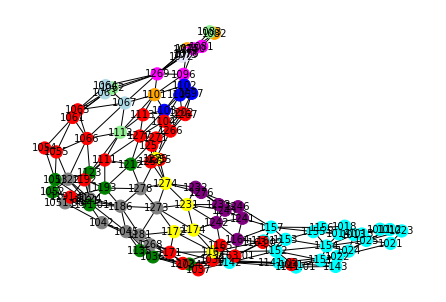

In [48]:
k = 12
test = mod_max(stl,k)
nx.write_gexf(test, "capstone.gexf")
colors = [test.nodes[node]['cluster'] for node in test.nodes()]
color_dict = {0:'lightgreen', 1:'lightblue', 2:'lavender', 3:'orange', 4:'red', 5:'purple', 6:'yellow', 7:'green', 8:'blue', 9:'magenta', 10:'cyan', 11:'gray'}
new_colors = [color_dict[key] for key in colors]
print(new_colors)
nx.draw(test, with_labels=True, node_size=150, node_color=new_colors, font_size=10)
plt.show()

## Getting centroid of each community and outputting as a new plan (output: point shapefile with all centroids containing a color attribute and a point shapefile comtaining the geomatric mean of each community, a new plan)
install geopandas and fiona to run.

In [73]:
import geopandas as gpd
from shapely.geometry import Point, LineString

centroids_shp = r"data\Centroids.shp"
centroids_gdf = gpd.read_file(centroids_shp)

# Add color information to centroids GeoDataFrame
centroids_gdf['color'] = new_colors

#match centroids with graph nodes using NAME field
nodes_data = []
for node, data in test.nodes(data=True):
    label = centroids_gdf.loc[centroids_gdf['NAME'] == str(node), 'NAME'].values[0]
    color = centroids_gdf.loc[centroids_gdf['NAME'] == str(node), 'color'].values[0]
    x, y = centroids_gdf.loc[centroids_gdf['NAME'] == str(node), 'geometry'].values[0].x, centroids_gdf.loc[centroids_gdf['NAME'] == str(node), 'geometry'].values[0].y
    intptlat = centroids_gdf.loc[centroids_gdf['NAME'] == str(node), 'INTPTLAT'].values[0]
    intptlon = centroids_gdf.loc[centroids_gdf['NAME'] == str(node), 'INTPTLON'].values[0]
    nodes_data.append({'node': node, 'color': color, 'geometry': Point(x, y), 'INTPTLAT': intptlat, 'INTPTLON': intptlon})

nodes_gdf = gpd.GeoDataFrame(nodes_data, geometry='geometry')

# Calculate geometric centroids by color!!!!!!!!!!!!!!!!!!!
centroid_data = nodes_gdf.groupby('color')['geometry'].apply(lambda x: x.unary_union.centroid)
centroid_gdf = gpd.GeoDataFrame(geometry=centroid_data)

# Add centroid coordinates as columns to nodes_gdf
newPlan = nodes_gdf.merge(centroid_gdf, left_on='color', right_index=True, suffixes=('', '_centroid'))
newPlan = newPlan.drop(columns=['geometry'])
newPlan = newPlan.rename(columns={'geometry_centroid': 'geometry'})
newPlan = newPlan.drop_duplicates(subset='color')

In [107]:
display(newPlan)
display(nodes_gdf)
newPlan.to_file(r"data\newPlanClust.shp",crs="EPSG:4326")
nodes_gdf.to_file(r"data\centroidsColoredByCommunity.shp",crs="EPSG:4326")

,node,color,INTPTLAT,INTPTLON,geometry
0,1232,purple,+38.6132904,-090.2137501,POINT (-90.26247 38.65949)
1,1274,cyan,+38.6201595,-090.2060528,POINT (-90.23981 38.64051)
2,1255,yellow,+38.6293098,-090.2029461,POINT (-90.24541 38.62729)
3,1256,red,+38.6271867,-090.1886661,POINT (-90.25157 38.63141)
4,1174,lightgreen,+38.6095244,-090.2373976,POINT (-90.25039 38.62556)
5,1157,gray,+38.5809512,-090.2353066,POINT (-90.25063 38.62422)
6,1161,green,+38.5922486,-090.2550617,POINT (-90.25389 38.62482)
7,1181,lightblue,+38.6235565,-090.2538984,POINT (-90.22347 38.66051)
8,1121,blue,+38.6404151,-090.2820820,POINT (-90.28009 38.61182)
9,1024,lavender,+38.5771575,-090.2778545,POINT (-90.27622 38.56604)


,node,color,geometry,INTPTLAT,INTPTLON
0,1232,purple,POINT (-90.21375 38.61329),+38.6132904,-090.2137501
1,1274,cyan,POINT (-90.20461 38.61989),+38.6201595,-090.2060528
2,1231,cyan,POINT (-90.22519 38.61128),+38.6112802,-090.2251869
3,1276,cyan,POINT (-90.19951 38.60417),+38.6038726,-090.1995009
4,1233,cyan,POINT (-90.21694 38.60564),+38.6056360,-090.2169446
5,1255,yellow,POINT (-90.20295 38.62931),+38.6293098,-090.2029461
6,1278,yellow,POINT (-90.22592 38.63195),+38.6319521,-090.2259200
7,1273,cyan,POINT (-90.23572 38.61930),+38.6192983,-090.2357220
8,1275,cyan,POINT (-90.21027 38.63749),+38.6374934,-090.2102717
9,1256,red,POINT (-90.18857 38.62750),+38.6271867,-090.1886661


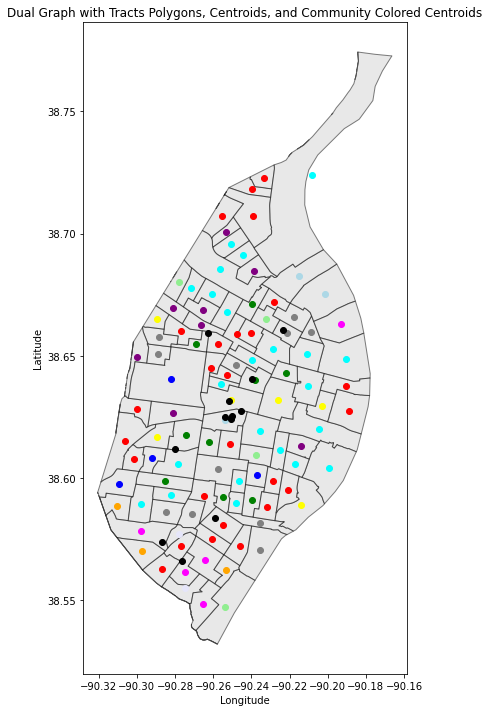

In [113]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Read the tracts shapefile
tracts = gpd.read_file(r"data\census tracts\CensusTractsStl.shp")

# Plotting the graph and tracts polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Plot tracts polygons
tracts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Create a colormap based on the 'color' field of coloredCentroids
colors_dict = {key: value for key, value in zip(coloredCentroids['color'], coloredCentroids['color'])}
colormap = ListedColormap(list(colors_dict.values()))

# Plot centroids from centroidsColoredByCommunity.shp with colormap
for _, row in coloredCentroids.iterrows():
    centroid = row['geometry'].centroid  # Get centroid of the polygon
    color = colors_dict[row['color']]
    ax.plot(centroid.x, centroid.y, marker='o', color=color)  # Use colormap for centroids

# Plot centroids of polygons from newPlanClust.shp
newPlan = gpd.read_file(r"data\newPlanClust.shp")
for _, row in newPlan.iterrows():
    centroid = row['geometry'].centroid  # Get centroid of the polygon
    ax.plot(centroid.x, centroid.y, marker='o', color='black')

ax.set_title('Dual Graph with Tracts Polygons, Centroids, and Community Colored Centroids')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()
